# Basic Recommendation Systems with Python and Pandas

This notebook will focus on providing a basic recommendation system for movies based similarities between them. What we will design here is not a true robust recommendation system but it just tells us about the movies (items) that are most similar to our movie of choice.

### Get the Data

We will use the [MovieLens dataset](https://grouplens.org/datasets/movielens/100k/) for this simple task. As mentioned on [data description site](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt), there are 100K ratings (1-5) from 943 users on 1682 movies and collected between September 19th, 1997 through April 22nd, 1998. 

We will use two of the files: 'u.data' and 'u.item' from that dataset. As described on site, 
- u.data is a tab separated list of `user_id, movie_id, rating, timestamp`
- u.item has 19 fields with `movie_id same as item_id of u.data, movie_title, release_date` etc. but we will use only first two columns.

In [1]:
#import some of the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# let's load all the columns of u.data into user dataframe
user = pd.read_csv('u.data', delimiter='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
# let's only load the first two columns of the file with usecols
movies = pd.read_csv('u.item', delimiter='|', names=['movie_id', 'movie_title'], usecols=range(2),
                     encoding='latin-1')

In [2]:
user.head()

,user_id,movie_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [3]:
movies.head()

,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### Merge the Data

Both user and movie data has common movie_id that we can use to merge these dataframes together.

In [4]:
df = pd.merge(user, movies, on='movie_id')
df.head()

,user_id,movie_id,rating,timestamp,movie_title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# Explore the Data 

We will do some data exploration and have a look at the titles of some of the best rated movies.

** Most Rated Movies **

In [5]:
df.movie_title.value_counts()[:10]

Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: movie_title, dtype: int64

** Mean rating **

In [6]:
df.groupby('movie_title')['rating'].mean().sort_values(ascending=False).head(10)

movie_title
Marlene Dietrich: Shadow and Light (1996)            5.0
Prefontaine (1997)                                   5.0
Santa with Muscles (1996)                            5.0
Star Kid (1997)                                      5.0
Someone Else's America (1995)                        5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Saint of Fort Washington, The (1993)                 5.0
Great Day in Harlem, A (1994)                        5.0
They Made Me a Criminal (1939)                       5.0
Aiqing wansui (1994)                                 5.0
Name: rating, dtype: float64

These five-star ratings could be from single user or a very few users, so we can't count them as quality films. We can't build a recommendation system based on such few user counts. So, let's create a dataframe that stores mean ratings and user counts per movie title. 

In [7]:
ratings = pd.DataFrame({'mean':df.groupby('movie_title')['rating'].mean(), 
                        'count':df.groupby('movie_title')['rating'].count()})
ratings.head(10)

,count,mean
movie_title,,
'Til There Was You (1997),9,2.333333
1-900 (1994),5,2.600000
101 Dalmatians (1996),109,2.908257
12 Angry Men (1957),125,4.344000
187 (1997),41,3.024390
2 Days in the Valley (1996),93,3.225806
"20,000 Leagues Under the Sea (1954)",72,3.500000
2001: A Space Odyssey (1968),259,3.969112
3 Ninjas: High Noon At Mega Mountain (1998),5,1.000000


As expected a few movies are rated by very few users. If we look at the jointplot for user counts vs average rating, we will notice some trend.

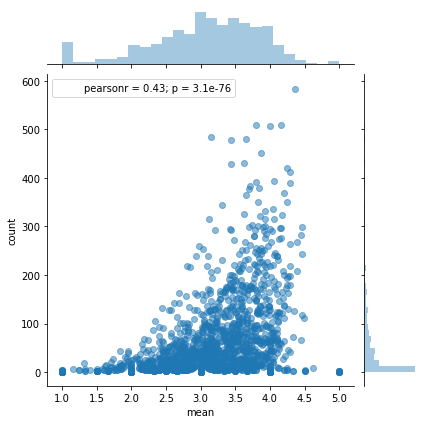

In [8]:
sns.jointplot(x='mean',y='count',data=ratings, alpha=0.5)

- We can notice on y-axis histogram, most of the movies have less than 100 number of ratings i.e. watched by very few users. This makes perfect sense as most people watch blockbusters or hit movies only.  
- Now on x-axis, we have average ratings that looks like normally distributed between 2.5 - 4.5 except for outliers at 1.0 or 5.0. 
- So, here the correlation plot would help us. We can see that as we get more number of users we're likely to have higher rating of the movie. That means better the movie, more are the watchers, and that leads to higher number of people reviewing the movie. Thus we see more data points between 3.0-4.0 mean ratings. 
- We can clearly see that the outliers in mean ratings could be explained by very few number of user ratings.

Now data makes some sense to us, so we can move on to creating a simple recommendation system.

## Recommendation for Similar Movies 

First of all let us use pandas.pivot_table method that will create a simple matrix with user_id as index, movie_title as columns and ratings as values. 

In [9]:
rate_pivot = df.pivot_table(index='user_id', columns='movie_title', values='rating')
rate_pivot.head()

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note there are a lot of NaN values, this is because most people have not watched most of the movies. 

Let's once again check the most watched movies sorted by average ratings.

In [10]:
ratings[ratings['count']>500].sort_values('mean',ascending=False).head(10)

,count,mean
movie_title,,
Star Wars (1977),584,4.359589
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Contact (1997),509,3.803536


Let's choose the top rated movie to build our recomendation system: 
  ** Star Wars, a sci-fi movie**
  
 Let's first grab the user ratings series for the choosen movie and find correlation of every other movie based on specific user behaviour on the choosen movie.

In [11]:
ratings_starwars = rate_pivot['Star Wars (1977)']
corrwith_starwars = rate_pivot.corrwith(ratings_starwars)
corrwith_starwars.head()

/home/lovedeep/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/lovedeep/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


movie_title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

This correlation coefficient tells us how correlated the user ratings's for the other movie are to the ones of the Star-wars. Now let us save the correlation coefficient for each movie title in a dataframe, and drop empty rows.

In [12]:
similar_starwars = pd.DataFrame(corrwith_starwars, columns=['correlation'])
similar_starwars.dropna(inplace=True)

If we sort above dataframe based on correlation factor in descending order, we should be able to get the most similar movies to Star-wars and hence our recommendation system. Let's check this.

In [13]:
similar_starwars.sort_values("correlation", ascending=False).head()

,correlation
movie_title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
"Beans of Egypt, Maine, The (1994)",1.0
Safe Passage (1994),1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Above dataframe gives us a list of movies showing perfect correlation factor of 1 to some rare movie titles. This is because there are some movies only watched once by users who also watched star wars. So, let's filter out such movies that have very few number of reviews. Based on our data exploration above, we can filter out those movies that don't have atleast 100 ratings. 

In [14]:
similar_starwars = similar_starwars.join(ratings['count'])
similar_starwars[similar_starwars['count']>100].sort_values('correlation',ascending=False).head()

,correlation,count
movie_title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


## Conclusions

Wow! we see first three movies in the list that are highly correlated are actually Star-wars movies!

We can play more with our filter (number of ratings > 100) or the movie category (sci-fi here) to make other preffered changes to the recommendation system, but let me just remind you that this notebook just aimed for making a basic system, and there we have it.

Next part of this article will talk about more advanced recommendation systems, so stay in touch!